# Load Dependencies

In [1]:
# -*- coding: unicode -*-

In [61]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
import gensim
import nltk
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, BatchNormalization, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import TensorBoard, EarlyStopping, Callback

In [3]:
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

In [4]:
assert gensim.models.doc2vec.FAST_VERSION > -1

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\insuf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\insuf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13134623936600785355
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 3129039257
locality {
  bus_id: 1
}
incarnation: 18284184963739995404
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0"
]


# Data Preprocessing

In [7]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

In [8]:
train = pd.read_csv('train_clean.csv')
train.comment_text = train.comment_text.astype(str)

In [254]:
list_classes = list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]

In [10]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
len(tokenizer.word_index)

223043

In [11]:
# totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
# plt.hist(totalNumWords)
# plt.show()

In [12]:
# meanLen = np.mean(totalNumWords)
# stdLen = np.std(totalNumWords)
# ub = meanLen + 2.576*stdLen/np.sqrt(len(totalNumWords))
# ub

In [13]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train,maxlen=maxlen,padding='post')

In [109]:
X_t[1]

array([  53, 2398,   13, 1351, 3461,   69, 4052, 2451,   21,   92,   41,
        898,  177,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [111]:
list_sentences_train[1]

'daww he matches this background colour im seemingly stuck with thanks talk january utc'

In [14]:
# list_sentences_train

In [15]:
# X_t[1]

In [16]:
# description = train.comment_text.values.tolist()
# stop_words = set(nltk.corpus.stopwords.words('english'))


# # Function to filter stop words from tokens for each sentence
# def sentence_filter(sentence_token, stop_words):
#     filtered = []
#     for token in sentence_token:
#         if not token in stop_words:
#             filtered.append(token)
#     return filtered


# # Input description, tokenize each sentence and return token for each sentence without stopping words
# def sentence_tokenizer(description, stop_words):
#     value = []
#     for sentence in description:
#         sentence = sentence.lower()
#         tokenizer_ = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')
#         sentence_token = tokenizer_.tokenize(sentence)
#         # sentence_token = nltk.word_tokenize(sentence)
#         filtered_token = sentence_filter(sentence_token, stop_words)
#         value.append(filtered_token)
#     return value


# # Tokenize the sentence
# description_token = sentence_tokenizer(description, stop_words)

In [17]:
# len(description_token)

In [18]:
# Skip gram model with minimum word count = 10 and output vector of length 300
# model_sg = gensim.models.Word2Vec(description_token, window=2, min_count=10, size=300, workers=4, seed=123, iter=10)

# CBOW(continuous bag of words) model
# model_cbow = gensim.models.Word2Vec(description_token, window=2, min_count=10, size=300, workers=4, seed=123, iter=10)

In [19]:
# model_sg.save('model_sg')

In [20]:
# model_cbow.save('model_cbow')

In [21]:
model_sg = gensim.models.Word2Vec.load('model_sg')

embed_size = 300
embeddings_index = dict()
for word in model_sg.wv.vocab:
    embeddings_index[word] = model_sg.wv[word]
print('Loaded %s word vectors.' % len(embeddings_index))

nb_words = min(max_features, len(tokenizer.word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
print('total embedded:',embeddedCount,'common words')

Loaded 25653 word vectors.
total embedded: 19861 common words


In [123]:
tokenizer.word_index['stuck']

2451

In [22]:
# model_cbow = gensim.models.Word2Vec.load('model_cbow')

# embed_size = 300
# embeddings_index = dict()
# for word in model_cbow.wv.vocab:
#     embeddings_index[word] = model_cbow.wv[word]
# print('Loaded %s word vectors.' % len(embeddings_index))

# nb_words = min(max_features, len(tokenizer.word_index))
# embedding_matrix = np.zeros((nb_words, embed_size))

# embeddedCount = 0
# for word, i in tokenizer.word_index.items():
#     if i >= max_features: continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector
#         embeddedCount += 1
# print('total embedded:',embeddedCount,'common words')

In [23]:
embedding_matrix.shape

(20000, 300)

In [24]:
# model_sg.wv.most_similar('rape')

In [25]:
def auc(y_true, y_pred):
     auc = tf.metrics.auc(y_true, y_pred)[1]
     K.get_session().run(tf.local_variables_initializer())
     return auc

In [42]:
def precision(y_true, y_pred):
    tp = tf.metrics.true_positives(y_true, y_pred)[1]
    fp = tf.metrics.false_positives(y_true, y_pred)[1]
    precision = tp/(tp+fp)
    K.get_session().run(tf.local_variables_initializer())
    return precision

In [43]:
def recall(y_true, y_pred):
    tp = tf.metrics.true_positives(y_true, y_pred)[1]
    fn = tf.metrics.false_negatives(y_true, y_pred)[1]
    recall = tp/(tp+fn)
    K.get_session().run(tf.local_variables_initializer())
    return recall

In [77]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_recalls = []
        self.val_precisions = []

    def on_batch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_recall = metrics.recall_score(val_targ, val_predict)
        _val_precision = metrics.precision_score(val_targ, val_predict)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_precision: {} — val_recall {}".format(_val_precision, _val_recall))
        return

pr = Metrics()

In [255]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y, train_size=0.9, random_state=123)

C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [256]:
model = Sequential()
model.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(6, activation="sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 25)           500000    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 200)               100800    
_________________________________________________________________
dense_31 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 306       
Total params: 611,156
Trainable params: 611,156
Non-trainable params: 0
_________________________________________________________________


In [249]:
# plot_model(model, to_file='model.png')

In [250]:
early = EarlyStopping(monitor="val_loss", mode="min")

In [257]:
with tf.device('/gpu:0'):
    history = model.fit(X_train,y_train,batch_size=256,epochs=4)

Epoch 1/4
143613/143613 [==============================] - 158s 1ms/step - loss: 0.0929 - auc: 0.8201
Epoch 2/4
143613/143613 [==============================] - 155s 1ms/step - loss: 0.0548 - auc: 0.9441
Epoch 3/4
143613/143613 [==============================] - 155s 1ms/step - loss: 0.0507 - auc: 0.9602
Epoch 4/4
143613/143613 [==============================] - 154s 1ms/step - loss: 0.0483 - auc: 0.9669


In [260]:
val_predict = (np.asarray(model.predict([X_val], batch_size=512))).round()
val_target = y_val

val_precision = []
val_recall = []
for i in range(6):
    val_precision.append(metrics.precision_score(val_target[:,i], val_predict[:,i]))
    val_recall.append(metrics.recall_score(val_target[:,i], val_predict[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {}".format(val_precision, val_recall))

Validation Precision: [0.85296381832178603, 0.5, 0.83445491251682369, 0.0, 0.74371069182389937, 0.0],

Validation Recall: [0.76308539944903586, 0.16, 0.76354679802955661, 0.0, 0.63489932885906042, 0.0]


C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
plt.plot(history.history['auc'], label="AUC")
plt.plot(history.history['val_auc'], label="Validation AUC")
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

## Try to Solve Underfitting

In [102]:
model1 = Sequential()
model1.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model1.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model1.add(Dense(50, activation="relu"))
model1.add(Dropout(0.1))
model1.add(Dense(6, activation="sigmoid"))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_15 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 306       
Total params: 6,331,156
Trainable params: 6,331,156
Non-trainable params: 0
_________________________________________________________________


In [194]:
plot_model(model1, to_file='model.png')

In [103]:
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 166s 1ms/step - loss: 0.0773 - auc: 0.8765 - val_loss: 0.0455 - val_auc: 0.9548
Epoch 2/10
143613/143613 [==============================] - 181s 1ms/step - loss: 0.0477 - auc: 0.9647 - val_loss: 0.0428 - val_auc: 0.9704
Epoch 3/10
143613/143613 [==============================] - 179s 1ms/step - loss: 0.0425 - auc: 0.9737 - val_loss: 0.0422 - val_auc: 0.9762
Epoch 4/10
143613/143613 [==============================] - 180s 1ms/step - loss: 0.0380 - auc: 0.9782 - val_loss: 0.0426 - val_auc: 0.9797


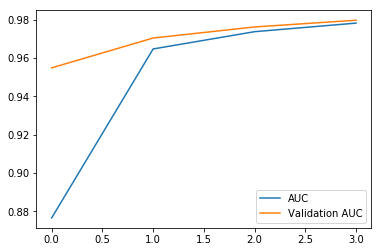

In [106]:
plt.plot(history1.history['auc'], label="AUC")
plt.plot(history1.history['val_auc'], label="Validation AUC")
plt.legend()
plt.show()

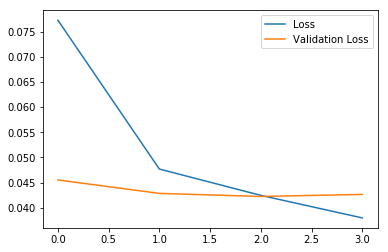

In [107]:
plt.plot(history1.history['loss'], label="Loss")
plt.plot(history1.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

In [143]:
val_predict1 = (np.asarray(model1.predict([X_val], batch_size=512))).round()

val_precision1 = []
val_recall1 = []
val_f11 = []
for i in range(6):
    val_precision1.append(metrics.precision_score(val_target[:,i], val_predict1[:,i]))
    val_recall1.append(metrics.recall_score(val_target[:,i], val_predict1[:,i]))
    val_f11.append(metrics.f1_score(val_target[:,i], val_predict1[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {},\n\nValidation F1: {}".format(val_precision1, val_recall1, val_f11))

Validation Precision: [0.86724960254372019, 0.47999999999999998, 0.83157894736842108, 0.80000000000000004, 0.77041602465331283, 0.58620689655172409],

Validation Recall: [0.75137741046831952, 0.080000000000000002, 0.77832512315270941, 0.088888888888888892, 0.67114093959731547, 0.29059829059829062],

Validation F1: [0.80516605166051658, 0.13714285714285715, 0.8040712468193385, 0.15999999999999998, 0.71736011477761841, 0.38857142857142862]


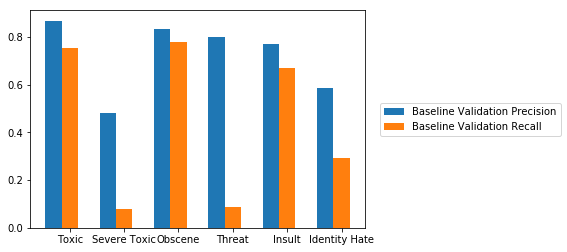

In [212]:
names = ["Toxic", "Severe Toxic", "Obscene", "Threat", "Insult", "Identity Hate"]

plt.bar(np.arange(6)-0.3/2, val_precision1, 0.3, label="Baseline Validation Precision", tick_label=names)
plt.bar(np.arange(6)+0.3/2, val_recall1, 0.3, label="Baseline Validation Recall", tick_label=names)

plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()

# Use GRU instead of LSTM

In [125]:
model2 = Sequential()
model2.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model2.add(Bidirectional(GRU(100,dropout=0.1,recurrent_dropout=0.1)))
model2.add(Dense(50, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(6, activation="sigmoid"))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 200)               240600    
_________________________________________________________________
dense_19 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 306       
Total params: 6,250,956
Trainable params: 6,250,956
Non-trainable params: 0
_________________________________________________________________


In [38]:
# plot_model(model2, to_file='model2.png')

In [126]:
with tf.device('/gpu:0'):
    history2 = model2.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 133s 923us/step - loss: 0.0736 - auc: 0.8847 - val_loss: 0.0443 - val_auc: 0.9601
Epoch 2/10
143613/143613 [==============================] - 146s 1ms/step - loss: 0.0460 - auc: 0.9684 - val_loss: 0.0423 - val_auc: 0.9731
Epoch 3/10
143613/143613 [==============================] - 148s 1ms/step - loss: 0.0409 - auc: 0.9761 - val_loss: 0.0423 - val_auc: 0.9782


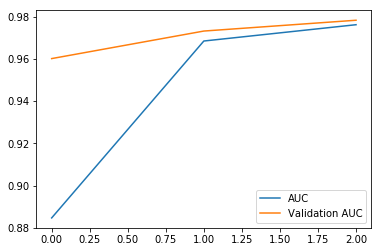

In [127]:
plt.plot(history2.history['auc'], label="AUC")
plt.plot(history2.history['val_auc'], label="Validation AUC")
plt.legend()
plt.show()

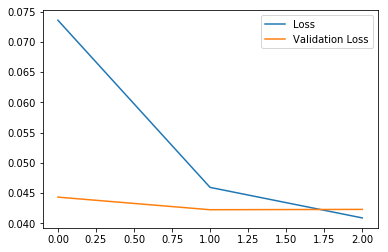

In [128]:
plt.plot(history2.history['loss'], label="Loss")
plt.plot(history2.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

In [144]:
val_predict2 = (np.asarray(model2.predict([X_val], batch_size=512))).round()

val_precision2 = []
val_recall2 = []
val_f12 = []
for i in range(6):
    val_precision2.append(metrics.precision_score(val_target[:,i], val_predict2[:,i]))
    val_recall2.append(metrics.recall_score(val_target[:,i], val_predict2[:,i]))
    val_f12.append(metrics.f1_score(val_target[:,i], val_predict2[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {},\n\nValidation F1: {}".format(val_precision2, val_recall2, val_f12))

Validation Precision: [0.8276627218934911, 0.43478260869565216, 0.82515723270440255, 0.0, 0.74198047419804747, 0.55555555555555558],

Validation Recall: [0.77066115702479343, 0.26666666666666666, 0.80788177339901479, 0.0, 0.71409395973154366, 0.42735042735042733],

Validation F1: [0.79814550641940085, 0.33057851239669422, 0.81642812694461731, 0.0, 0.72777017783857734, 0.48309178743961351]


C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


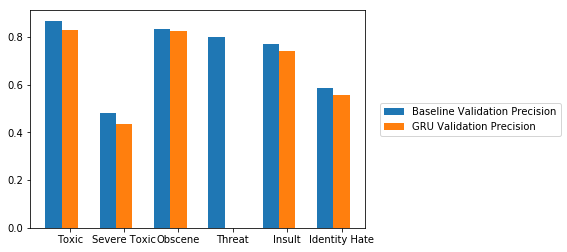

In [213]:
plt.bar(np.arange(6) - 0.3/2,val_precision1,0.3,label="Baseline Validation Precision", tick_label=names)
plt.bar(np.arange(6) + 0.3/2,val_precision2,0.3,label="GRU Validation Precision", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()

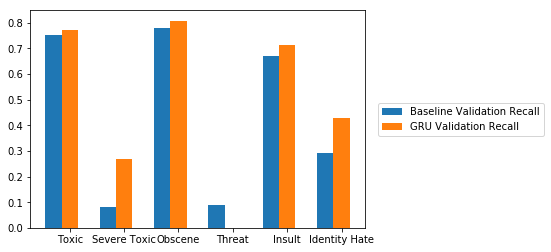

In [220]:
plt.bar(np.arange(6) - 0.3/2,val_recall1,0.3,label="Baseline Validation Recall", tick_label=names)
plt.bar(np.arange(6) + 0.3/2,val_recall2,0.3,label="GRU Validation Recall", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.55,0.5))
plt.show()

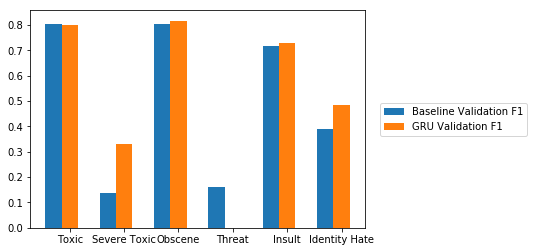

In [218]:
plt.bar(np.arange(6) - 0.3/2,val_f11,0.3,label="Baseline Validation F1", tick_label=names)
plt.bar(np.arange(6) + 0.3/2,val_f12,0.3,label="GRU Validation F1", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.5,0.5))
plt.show()

# Use Pre-trained Embedding - GoogleNews Negative 3mil

In [221]:
word2vecDict = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format(
    r"C:\Users\insuf\Desktop\GoogleNews-vectors-negative300.bin", binary=True)

embed_size = 300
embeddings_index = dict()
for word in word2vecDict.wv.vocab:
    embeddings_index[word] = word2vecDict.wv[word]
print('Loaded %s word vectors.' % len(embeddings_index))

nb_words = min(max_features, len(tokenizer.word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
print('total embedded:',embeddedCount,'common words')

C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


Loaded 3000000 word vectors.
total embedded: 17855 common words


In [222]:
model3 = Sequential()
model3.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model3.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model3.add(Dense(50, activation="relu"))
model3.add(Dropout(0.1))
model3.add(Dense(6, activation="sigmoid"))
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 200)               320800    
_________________________________________________________________
dense_21 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 306       
Total params: 6,331,156
Trainable params: 6,331,156
Non-trainable params: 0
_________________________________________________________________


In [223]:
with tf.device('/gpu:0'):
    history3 = model3.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 206s 1ms/step - loss: 0.0864 - auc: 0.8289 - val_loss: 0.0457 - val_auc: 0.9404
Epoch 2/10
143613/143613 [==============================] - 215s 1ms/step - loss: 0.0485 - auc: 0.9562 - val_loss: 0.0446 - val_auc: 0.9646
Epoch 3/10
143613/143613 [==============================] - 214s 1ms/step - loss: 0.0424 - auc: 0.9696 - val_loss: 0.0444 - val_auc: 0.9730
Epoch 4/10
143613/143613 [==============================] - 216s 2ms/step - loss: 0.0375 - auc: 0.9757 - val_loss: 0.0447 - val_auc: 0.9778


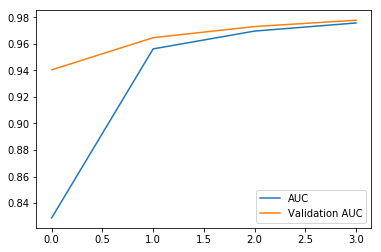

In [224]:
plt.plot(history3.history['auc'], label="AUC")
plt.plot(history3.history['val_auc'], label="Validation AUC")
plt.legend()
plt.show()

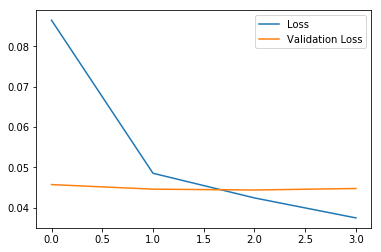

In [225]:
plt.plot(history3.history['loss'], label="Loss")
plt.plot(history3.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

In [226]:
val_predict3 = (np.asarray(model3.predict([X_val], batch_size=512))).round()

val_precision3 = []
val_recall3 = []
val_f13 = []
for i in range(6):
    val_precision3.append(metrics.precision_score(val_target[:,i], val_predict3[:,i]))
    val_recall3.append(metrics.recall_score(val_target[:,i], val_predict3[:,i]))
    val_f13.append(metrics.f1_score(val_target[:,i], val_predict3[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {},\n\nValidation F1: {}".format(val_precision3, val_recall3, val_f13))

Validation Precision: [0.80522230063514466, 0.44, 0.82694848084544259, 0.0, 0.71941489361702127, 0.68181818181818177],

Validation Recall: [0.78581267217630857, 0.22, 0.77093596059113301, 0.0, 0.72617449664429534, 0.25641025641025639],

Validation F1: [0.79539909376089235, 0.29333333333333333, 0.79796048438495859, 0.0, 0.72277889111556448, 0.37267080745341608]


C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Glove Twitter 27B

In [227]:
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove2word2vec(r"C:\Users\insuf\Desktop\glove.twitter.27B.25d.txt", r"C:\Users\insuf\Desktop\glove.twitter.27B.25d.w2v.txt")

In [228]:
glove = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format(r"C:\Users\insuf\Desktop\glove.twitter.27B.25d.w2v.txt")

embed_size = 25
embeddings_index = dict()
for word in glove.wv.vocab:
    embeddings_index[word] = glove.wv[word]
print('Loaded %s word vectors.' % len(embeddings_index))

nb_words = min(max_features, len(tokenizer.word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
print('total embedded:',embeddedCount,'common words')

C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Loaded 1193515 word vectors.
total embedded: 18569 common words


In [229]:
model4 = Sequential()
model4.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model4.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model4.add(Dense(50, activation="relu"))
model4.add(Dropout(0.1))
model4.add(Dense(6, activation="sigmoid"))
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 25)           500000    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 200)               100800    
_________________________________________________________________
dense_23 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 306       
Total params: 611,156
Trainable params: 611,156
Non-trainable params: 0
_________________________________________________________________


In [230]:
with tf.device('/gpu:0'):
    history4 = model4.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 197s 1ms/step - loss: 0.0996 - auc: 0.8017 - val_loss: 0.0509 - val_auc: 0.9215
Epoch 2/10
143613/143613 [==============================] - 195s 1ms/step - loss: 0.0552 - auc: 0.9419 - val_loss: 0.0470 - val_auc: 0.9531
Epoch 3/10
143613/143613 [==============================] - 195s 1ms/step - loss: 0.0513 - auc: 0.9590 - val_loss: 0.0464 - val_auc: 0.9631
Epoch 4/10
143613/143613 [==============================] - 196s 1ms/step - loss: 0.0491 - auc: 0.9659 - val_loss: 0.0444 - val_auc: 0.9682
Epoch 5/10
143613/143613 [==============================] - 195s 1ms/step - loss: 0.0468 - auc: 0.9701 - val_loss: 0.0443 - val_auc: 0.9717
Epoch 6/10
143613/143613 [==============================] - 195s 1ms/step - loss: 0.0450 - auc: 0.9730 - val_loss: 0.0437 - val_auc: 0.9741
Epoch 7/10
143613/143613 [==============================] - 195s 1ms/step - loss: 0.0433 - auc: 0.9751 - val_

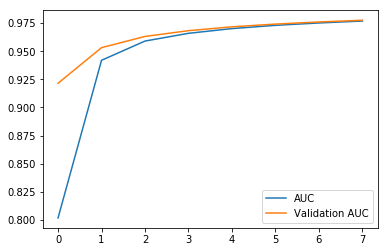

In [231]:
plt.plot(history4.history['auc'], label="AUC")
plt.plot(history4.history['val_auc'], label="Validation AUC")
plt.legend()
plt.show()

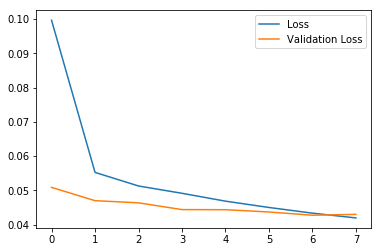

In [232]:
plt.plot(history4.history['loss'], label="Loss")
plt.plot(history4.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

In [233]:
val_predict4 = (np.asarray(model4.predict([X_val], batch_size=512))).round()

val_precision4 = []
val_recall4 = []
val_f14 = []
for i in range(6):
    val_precision4.append(metrics.precision_score(val_target[:,i], val_predict4[:,i]))
    val_recall4.append(metrics.recall_score(val_target[:,i], val_predict4[:,i]))
    val_f14.append(metrics.f1_score(val_target[:,i], val_predict4[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {},\n\nValidation F1: {}".format(val_precision4, val_recall4, val_f14))

Validation Precision: [0.84167289021657954, 0.52307692307692311, 0.84069611780455156, 0.0, 0.74340175953079179, 0.66666666666666663],

Validation Recall: [0.77617079889807161, 0.22666666666666666, 0.77339901477832518, 0.0, 0.68053691275167782, 0.22222222222222221],

Validation F1: [0.80759584378359006, 0.31627906976744186, 0.80564464400256586, 0.0, 0.71058163980378408, 0.33333333333333331]


C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Overall Comparison

In [3]:
from matplotlib import pyplot as plt
plt.plot(history1.history['auc'], label="Baseline Training AUC")
plt.plot(history3.history['auc'], label="Pretrained w2v Training AUC")
plt.plot(history4.history['auc'], label="Pretrained glove Training AUC")
plt.legend()
plt.show()

NameError: name 'history1' is not defined

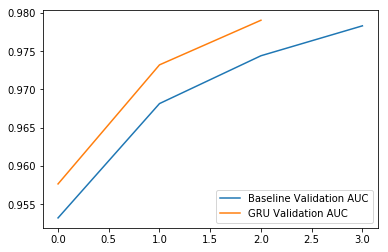

In [96]:
plt.plot(history.history['val_auc'], label="Baseline Validation AUC")
plt.plot(history2.history['val_auc'], label="GRU Validation AUC")
plt.legend()
plt.show()

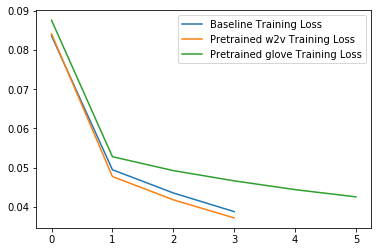

In [95]:
plt.plot(history.history['loss'], label="Baseline Training Loss")
plt.plot(history3.history['loss'], label="Pretrained w2v Training Loss")
plt.plot(history4.history['loss'], label="Pretrained glove Training Loss")
plt.legend()
plt.show()

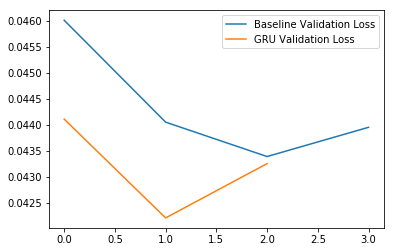

In [97]:
plt.plot(history.history['val_loss'], label="Baseline Validation Loss")
plt.plot(history2.history['val_loss'], label="GRU Validation Loss")
plt.legend()
plt.show()

In [89]:
model_sg = gensim.models.Word2Vec.load('model_sg')

embed_size = 300
embeddings_index = dict()
for word in model_sg.wv.vocab:
    embeddings_index[word] = model_sg.wv[word]
print('Loaded %s word vectors.' % len(embeddings_index))

nb_words = min(max_features, len(tokenizer.word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
print('total embedded:',embeddedCount,'common words')

Loaded 25653 word vectors.
total embedded: 19861 common words


In [90]:
model5 = Sequential()
model5.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen,trainable=False))
model5.add(Bidirectional(LSTM(100, return_sequences=True,dropout=0.1,recurrent_dropout=0.1)))
model5.add(Dense(50, activation="relu"))
model5.add(Dropout(0.1))
model5.add(Dense(6, activation="sigmoid"))
model5.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
with tf.device('/gpu:0'):
    history5 = model5.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 189s 1ms/step - loss: 0.0771 - auc: 0.8753 - val_loss: 0.0488 - val_auc: 0.9532
Epoch 2/10
143613/143613 [==============================] - 186s 1ms/step - loss: 0.0534 - auc: 0.9618 - val_loss: 0.0466 - val_auc: 0.9669
Epoch 3/10
143613/143613 [==============================] - 185s 1ms/step - loss: 0.0502 - auc: 0.9698 - val_loss: 0.0454 - val_auc: 0.9720
Epoch 4/10
143613/143613 [==============================] - 185s 1ms/step - loss: 0.0478 - auc: 0.9736 - val_loss: 0.0445 - val_auc: 0.9748
Epoch 5/10
143613/143613 [==============================] - 185s 1ms/step - loss: 0.0460 - auc: 0.9759 - val_loss: 0.0462 - val_auc: 0.9768


In [235]:
model9 = Sequential()
model9.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model9.add(Bidirectional(LSTM(200,dropout=0.1,recurrent_dropout=0.1)))
model9.add(Dense(100, activation="relu"))
model9.add(Dropout(0.1))
model9.add(Dense(6, activation="sigmoid"))
model9.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 25)           500000    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 400)               361600    
_________________________________________________________________
dense_25 (Dense)             (None, 100)               40100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 606       
Total params: 902,306
Trainable params: 902,306
Non-trainable params: 0
_________________________________________________________________


In [236]:
with tf.device('/gpu:0'):
    history1 = model9.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 199s 1ms/step - loss: 0.0864 - auc: 0.8487 - val_loss: 0.0503 - val_auc: 0.9378
Epoch 2/10
143613/143613 [==============================] - 192s 1ms/step - loss: 0.0540 - auc: 0.9521 - val_loss: 0.0461 - val_auc: 0.9601
Epoch 3/10
143613/143613 [==============================] - 192s 1ms/step - loss: 0.0502 - auc: 0.9643 - val_loss: 0.0459 - val_auc: 0.9675
Epoch 4/10
143613/143613 [==============================] - 189s 1ms/step - loss: 0.0476 - auc: 0.9698 - val_loss: 0.0433 - val_auc: 0.9716
Epoch 5/10
143613/143613 [==============================] - 188s 1ms/step - loss: 0.0451 - auc: 0.9732 - val_loss: 0.0430 - val_auc: 0.9745
Epoch 6/10
143613/143613 [==============================] - 190s 1ms/step - loss: 0.0435 - auc: 0.9756 - val_loss: 0.0419 - val_auc: 0.9765
Epoch 7/10
143613/143613 [==============================] - 189s 1ms/step - loss: 0.0417 - auc: 0.9774 - val_

In [237]:
val_predict9 = (np.asarray(model9.predict([X_val], batch_size=512))).round()

val_precision9 = []
val_recall9 = []
val_f19 = []
for i in range(6):
    val_precision9.append(metrics.precision_score(val_target[:,i], val_predict9[:,i]))
    val_recall9.append(metrics.recall_score(val_target[:,i], val_predict9[:,i]))
    val_f19.append(metrics.f1_score(val_target[:,i], val_predict9[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {},\n\nValidation F1: {}".format(val_precision9, val_recall9, val_f19))

Validation Precision: [0.83580980683506689, 0.45238095238095238, 0.81762545899632799, 1.0, 0.70915841584158412, 0.55844155844155841],

Validation Recall: [0.77479338842975209, 0.25333333333333335, 0.82266009852216748, 0.022222222222222223, 0.76912751677852353, 0.36752136752136755],

Validation F1: [0.80414581844174404, 0.3247863247863248, 0.8201350521792512, 0.043478260869565223, 0.73792659368963298, 0.44329896907216498]


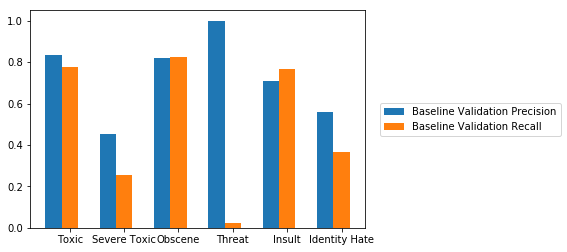

In [238]:
plt.bar(np.arange(6)-0.3/2, val_precision9, 0.3, label="Baseline Validation Precision", tick_label=names)
plt.bar(np.arange(6)+0.3/2, val_recall9, 0.3, label="Baseline Validation Recall", tick_label=names)

plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()

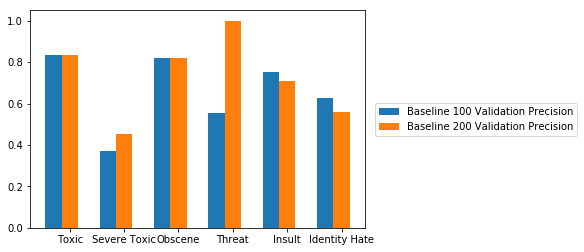

In [242]:
plt.bar(np.arange(6)-0.3/2, val_precision, 0.3, label="Baseline 100 Validation Precision", tick_label=names)
plt.bar(np.arange(6)+0.3/2, val_precision9, 0.3, label="Baseline 200 Validation Precision", tick_label=names)

plt.legend(loc='right', bbox_to_anchor=(1.65,0.5))
plt.show()

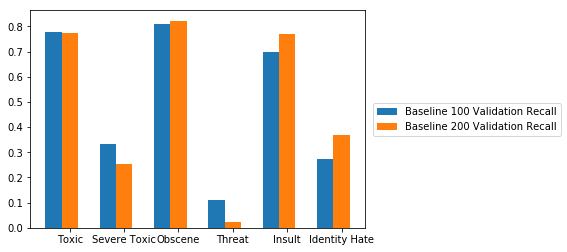

In [240]:
plt.bar(np.arange(6)-0.3/2, val_recall, 0.3, label="Baseline 100 Validation Recall", tick_label=names)
plt.bar(np.arange(6)+0.3/2, val_recall9, 0.3, label="Baseline 200 Validation Recall", tick_label=names)

plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()